# CSCA 5632 Unsupervised Algorithms in Machine Learning Final Project

This project is about developing an unsupervised machine learning model to cluster the user data into various segments. In this project we will use K-means clustering and Gaussian Mixture Model in order to create the segments/cluster. Segmentation and personalization are critical strategies in modern business, particularly in marketing, customer service, and e-commerce. Clustering, as a method of segmentation, helps businesses understand and cater to the diverse needs and preferences of their customer base. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import RobustScaler

from itertools import permutations

from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import StackingClassifier


# Data
1. The data was obtained from kaggle, and contains loan default information
2. Kaggle, Kaggle Dataset. (2021). Loan Default Dataset [Data Set](https://www.kaggle.com/datasets/yasserh/loan-default-dataset/data). Kaggle. https://www.kaggle.com/datasets/yasserh/loan-default-dataset/data
3. Dat can  be downloaded from [here](https://www.kaggle.com/datasets/tzuchjehwu/loan-default-dataset as well)

In [4]:
data = pd.read_csv("data/loan_default.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

In [5]:
data.describe()

,ID,year,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status,dtir1
count,148670.000000,148670.0,1.486700e+05,112231.000000,112031.000000,109028.000000,148629.000000,1.335720e+05,139520.000000,148670.000000,133572.000000,148670.000000,124549.000000
mean,99224.500000,2019.0,3.311177e+05,4.045476,0.441656,3224.996127,335.136582,4.978935e+05,6957.338876,699.789103,72.746457,0.246445,37.732932
std,42917.476598,0.0,1.839093e+05,0.561391,0.513043,3251.121510,58.409084,3.599353e+05,6496.586382,115.875857,39.967603,0.430942,10.545435
min,24890.000000,2019.0,1.650000e+04,0.000000,-3.638000,0.000000,96.000000,8.000000e+03,0.000000,500.000000,0.967478,0.000000,5.000000
25%,62057.250000,2019.0,1.965000e+05,3.625000,0.076000,581.490000,360.000000,2.680000e+05,3720.000000,599.000000,60.474860,0.000000,31.000000
50%,99224.500000,2019.0,2.965000e+05,3.990000,0.390400,2596.450000,360.000000,4.180000e+05,5760.000000,699.000000,75.135870,0.000000,39.000000
75%,136391.750000,2019.0,4.365000e+05,4.375000,0.775400,4812.500000,360.000000,6.280000e+05,8520.000000,800.000000,86.184211,0.000000,45.000000
max,173559.000000,2019.0,3.576500e+06,8.000000,3.357000,60000.000000,360.000000,1.650800e+07,578580.000000,900.000000,7831.250000,1.000000,61.000000


In [6]:
unnecessary_features = ['ID','year']
data.drop(columns=unnecessary_features, inplace=True)
unique_values_dict = {col: data[col].unique() for col in data.columns}

for col, unique_vals in unique_values_dict.items():
    print(f"Unique values in {col}: {unique_vals}")



Unique values in loan_limit: ['cf' nan 'ncf']
Unique values in Gender: ['Sex Not Available' 'Male' 'Joint' 'Female']
Unique values in approv_in_adv: ['nopre' 'pre' nan]
Unique values in loan_type: ['type1' 'type2' 'type3']
Unique values in loan_purpose: ['p1' 'p4' 'p3' 'p2' nan]
Unique values in Credit_Worthiness: ['l1' 'l2']
Unique values in open_credit: ['nopc' 'opc']
Unique values in business_or_commercial: ['nob/c' 'b/c']
Unique values in loan_amount: [ 116500  206500  406500  456500  696500  706500  346500  266500  376500
  436500  136500  466500  226500   76500  356500  156500  586500  306500
  316500  336500  426500  476500  196500  186500  246500  216500  506500
  656500  256500  396500  166500  236500  866500  416500  386500  596500
  606500   86500  286500  146500  446500  636500  486500  326500   56500
  906500  496500  106500  126500  296500  176500 1376500  566500  686500
  556500  676500  366500  276500  716500   66500  616500   96500  826500
   26500  666500  546500  986

,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,116500,NaN,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,cf,Male,nopre,type2,p1,l1,nopc,b/c,206500,NaN,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,cf,Male,pre,type1,p1,l1,nopc,nob/c,406500,4.56,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,cf,Male,nopre,type1,p4,l1,nopc,nob/c,456500,4.25,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,cf,Joint,pre,type1,p1,l1,nopc,nob/c,696500,4.00,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [82]:
nan_percentage = data.isna().mean() * 100

print(nan_percentage)



Status                  0.0
loan_amount             0.0
rate_of_interest        0.0
Interest_rate_spread    0.0
Upfront_charges         0.0
property_value          0.0
income                  0.0
Credit_Score            0.0
LTV                     0.0
dtir1                   0.0
KMeans_Cluster          0.0
GMM_Cluster             0.0
dtype: float64


In [83]:
display(data.head())

,Status,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,property_value,income,Credit_Score,LTV,dtir1,KMeans_Cluster,GMM_Cluster
0,0,-0.782609,0.000000,0.000000,0.000000,-1.153846,-1.080645,0.293532,1.261238,0.666667,0,1
1,0,-0.391304,0.000000,0.000000,0.000000,0.000000,-0.209677,-0.731343,0.000000,0.000000,1,1
2,0,0.478261,1.868852,-0.654520,-1.026385,0.346154,1.000000,0.671642,0.261080,0.777778,2,0
3,0,0.695652,0.852459,0.998969,0.000000,0.923077,1.645161,-0.557214,-0.307864,0.333333,2,0
4,0,1.739130,0.032787,-0.296322,-1.331513,1.307692,1.258065,-0.482587,0.895462,0.000000,2,0


# Summary of data set information

| Metric                         | Value   |
|--------------------------------|---------|
| Number of rows                 | 148,670 |
| Number of features             | 34      |
| Filesize (MB)                  | 38.6+   |
| Number of categorical features | 25      |
| Number of numeric features     | 7       |
| Number of unnecessary features | 2       |

1. Intuitively, the key features are `loan_amount`, `rate_of_interest`, `income` and `credit score`


# Exploratory Data Analysis

## Visual Data Exploration (Numeric Data Analysis)

The first step in our exploratory data analysis is to render histograms as subplots. This allows us to visually understand the distribution of our data across various features.
Upon examining the histograms, we observed that most of the data distributions deviate significantly from normality.This has to be handled later using a scaler, such as RobustScaler as well as imputation of missing values.


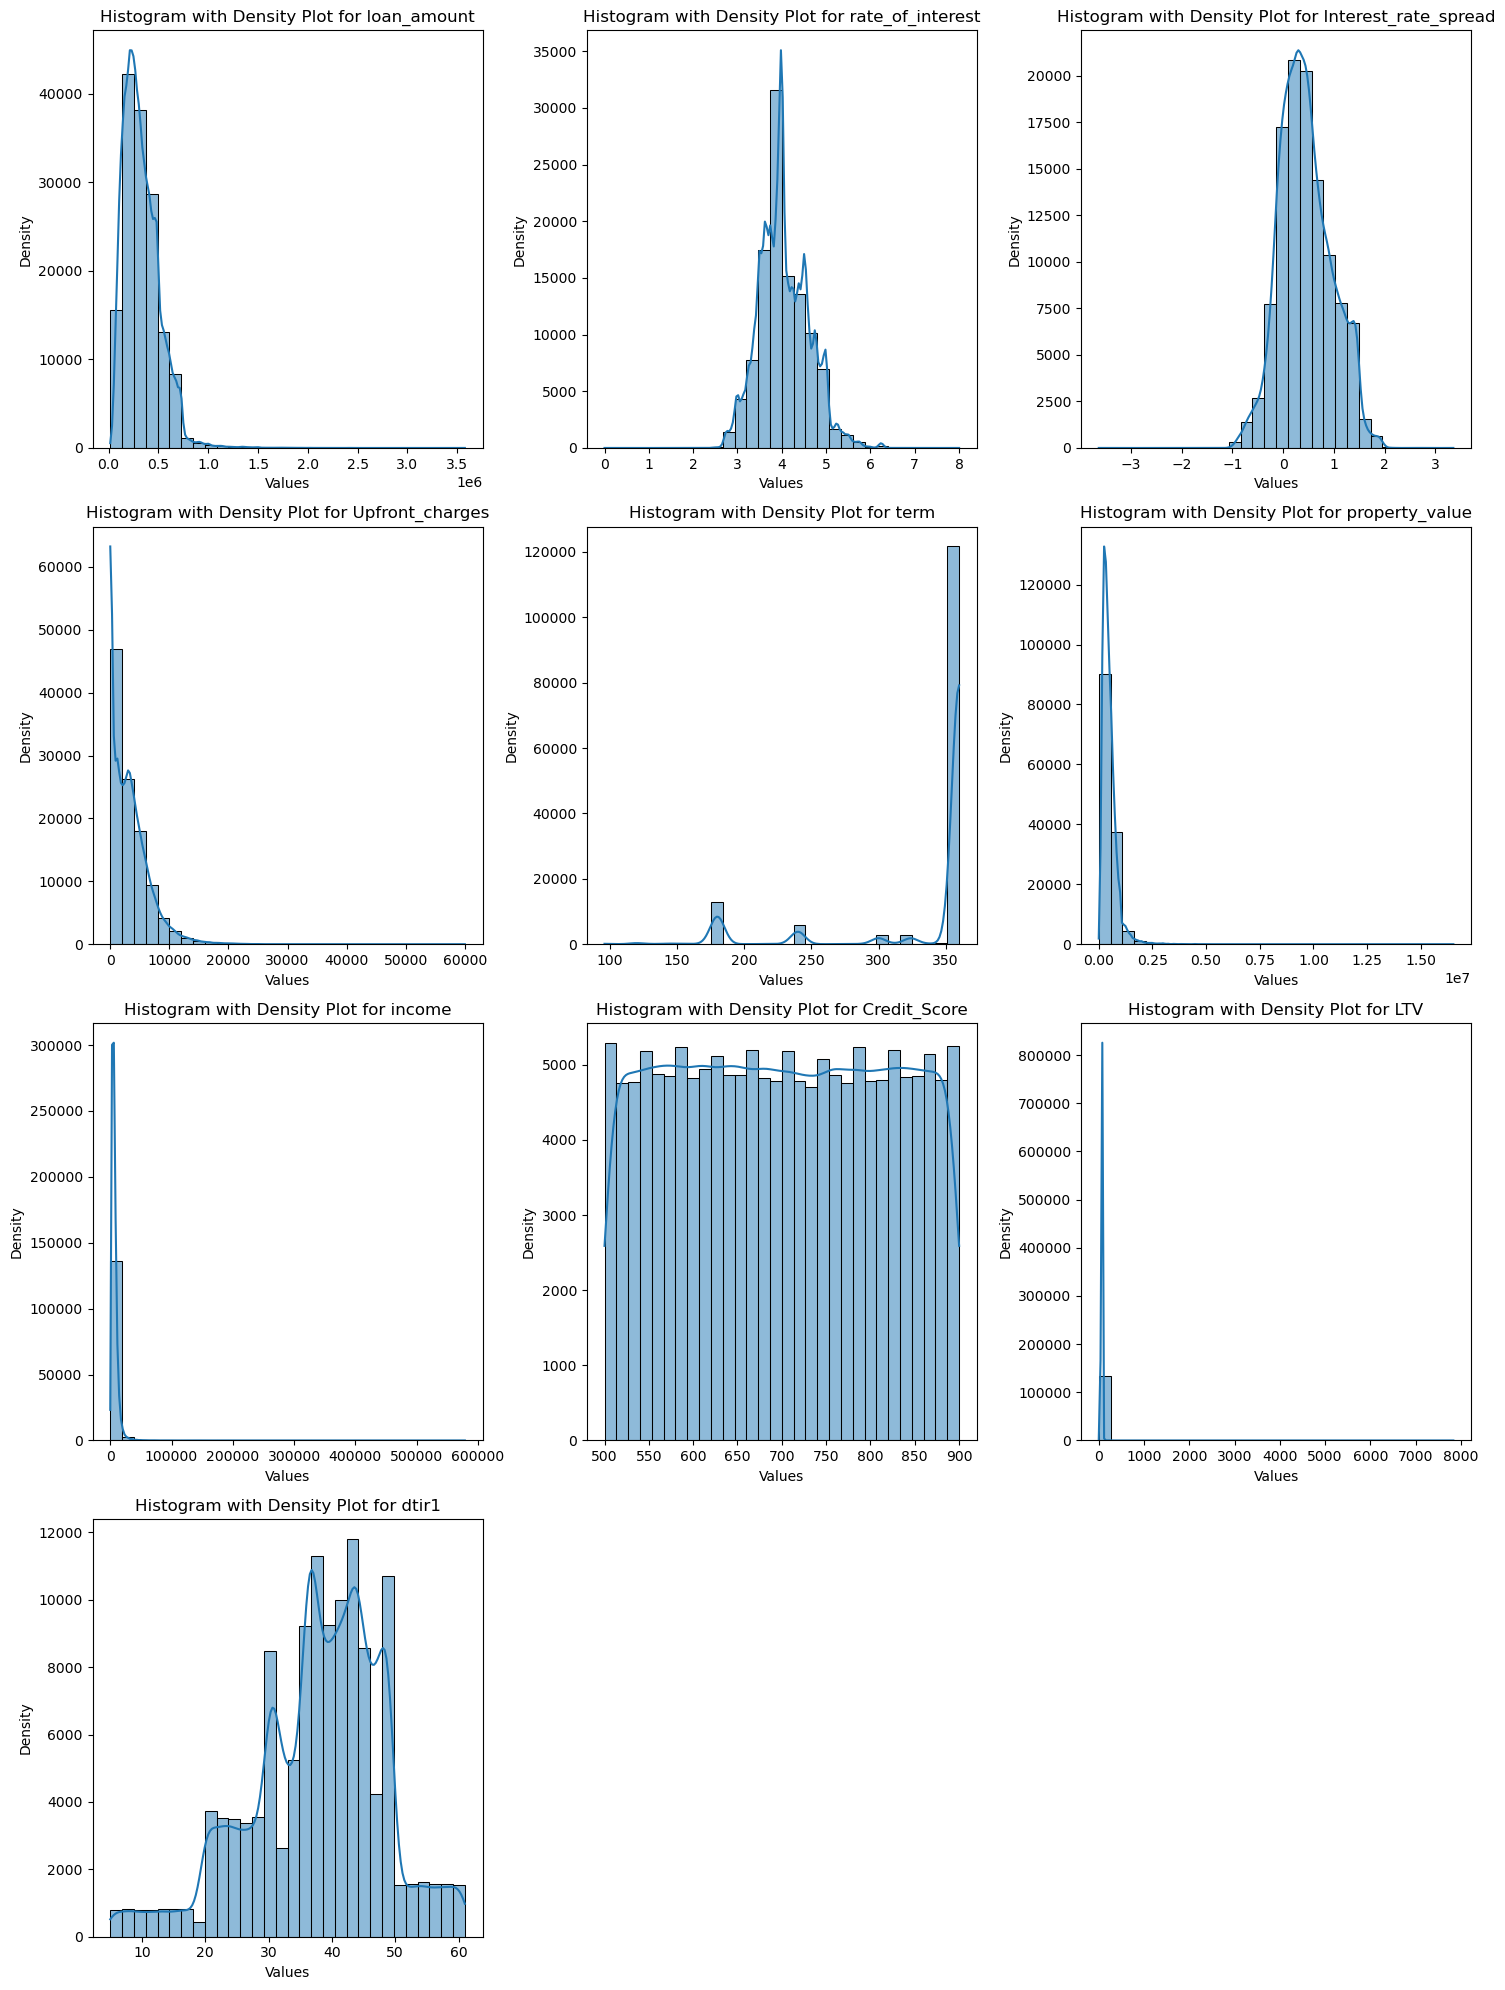

In [9]:
# Plot histograms for each numeric feature in one chart
numeric_data = data.select_dtypes(include=['number']).drop(columns=['Status'])
num_features = numeric_data.shape[1]
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols

plt.figure(figsize=(15, num_rows * 5))

for i, feature in enumerate(numeric_data.columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(numeric_data[feature], bins=30, kde=True, edgecolor='black')
    plt.xlabel('Values')
    plt.ylabel('Density')
    plt.title(f'Histogram with Density Plot for {feature}')

plt.tight_layout()
plt.show()

## Comments
Determine how much of the data consists of NaNs by column

In [11]:
data.isnull().sum()

loan_limit                    3344
Gender                           0
approv_in_adv                  908
loan_type                        0
loan_purpose                   134
Credit_Worthiness                0
open_credit                      0
business_or_commercial           0
loan_amount                      0
rate_of_interest             36439
Interest_rate_spread         36639
Upfront_charges              39642
term                            41
Neg_ammortization              121
interest_only                    0
lump_sum_payment                 0
property_value               15098
construction_type                0
occupancy_type                   0
Secured_by                       0
total_units                      0
income                        9150
credit_type                      0
Credit_Score                     0
co-applicant_credit_type         0
age                            200
submission_of_application      200
LTV                          15098
Region              

# Determine missing data

We want to determine what the percentage of missing data looks like

In [13]:

# Calculate the percentage of missing values for each column
missing_percentage = (data.isnull().sum() / len(data)) * 100

# Print the percentage of missing values for each column
print(missing_percentage)

loan_limit                    2.249277
Gender                        0.000000
approv_in_adv                 0.610749
loan_type                     0.000000
loan_purpose                  0.090133
Credit_Worthiness             0.000000
open_credit                   0.000000
business_or_commercial        0.000000
loan_amount                   0.000000
rate_of_interest             24.509989
Interest_rate_spread         24.644515
Upfront_charges              26.664425
term                          0.027578
Neg_ammortization             0.081388
interest_only                 0.000000
lump_sum_payment              0.000000
property_value               10.155378
construction_type             0.000000
occupancy_type                0.000000
Secured_by                    0.000000
total_units                   0.000000
income                        6.154571
credit_type                   0.000000
Credit_Score                  0.000000
co-applicant_credit_type      0.000000
age                      

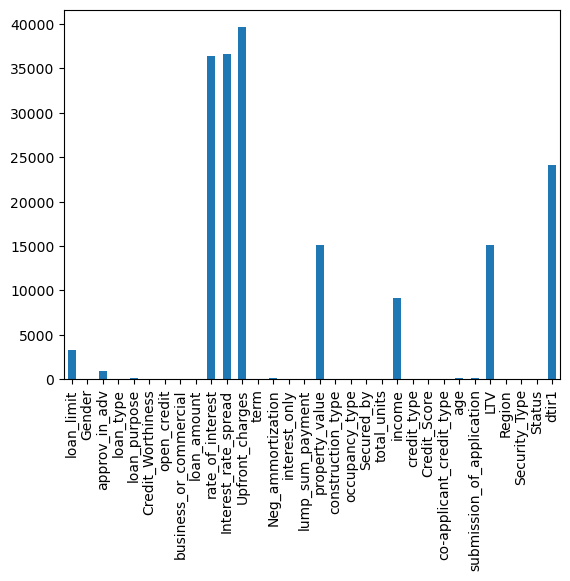

In [14]:
data.isna().sum().plot.bar()
plt.show()

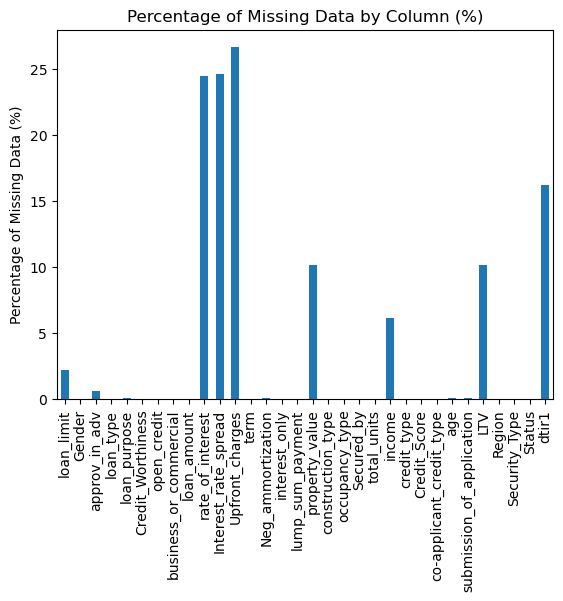

In [15]:
# Calculate the percentage of missing values for each column
missing_percentage = (data.isna().sum() / len(data)) * 100

# Plot the missing percentages as a bar chart
missing_percentage.plot.bar()

# Add labels and title
plt.ylabel('Percentage of Missing Data (%)')
plt.title('Percentage of Missing Data by Column (%)')

# Show the plot
plt.show()

## Summary of data analysis
The 'Percentage of Missing Data by Column (%) diagram shows the percentage of missing data for each column in the dataset. Key takeaways include:

1. **High Missing Data**: Columns like `rate_of_interest`, `Interest_rate_spread`, and `upfront_charges` have around 25-28% missing data, which could impact the analysis if not addressed.

2. **Low Missing Data**: Columns such as `loan_limit`, `Gender`, and `approval_in_adv` have minimal missing data, making them more reliable for analysis.

3. **Actionable Steps**: Consider data imputation for columns with moderate missing data or possibly exclude those with very high missing data to maintain the quality of your analysis. Also, assess whether the missing data is random or patterned, as this will influence your approach to handling it.

## Data Preprocessing
1. We begin by removing duplicates and earlier we have removed `ID` and `year` which were determined to be non useful.
2. We perform null value imputation

In [18]:
# drop duplicate
data.drop_duplicates(inplace=True)
data = data.dropna(how='all')

# set a column's datatype as categorical or numeric
categorical_columns = ['loan_limit', 'Gender', 'approv_in_adv', 
                       'loan_type', 'loan_purpose','Credit_Worthiness', 'open_credit',
                       'business_or_commercial','term','Neg_ammortization','interest_only',
                       'lump_sum_payment','Neg_ammortization','construction_type',
                       'occupancy_type','Secured_by','total_units','credit_type',
                       'co-applicant_credit_type','age','submission_of_application','Region',
                       'Security_Type'
                       ]
numerical_columns = ['Status','loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'property_value', 'income', 'Credit_Score', 'LTV', 'dtir1']

In [19]:
# missing values with mode
for column in categorical_columns:
    if column in data.columns:
        data[column] = data[column].fillna(data[column].mode()[0])

# missing values with median
for column in numerical_columns:
    if column in data.columns:
        data[column] = data[column].fillna(data[column].median())

# Replace outliers with median
for column in numerical_columns:
    if column in data.columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        median = data[column].median()
        data[column] = np.where((data[column] < lower_bound) | (data[column] > upper_bound), median, data[column])

    
# Use one-hot encoding to convert categorical variables into numerical format.
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Encode the target variable 'Status' as numeric.
data['Status'] = data['Status'].astype(int)


# Normalize/scale numerical features
scaler = RobustScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

data['Status'] = data['Status'].astype('category').cat.codes



## Summary of imputation and clean up

1. We now check if any field still has missing values in the form of null value checks

In [21]:
missing_values = data.isnull().sum()
print(missing_values)
missing_columns = data.isnull().any()
print(missing_columns)
has_nan = data.isnull().values.any()
print(f'Does the DataFrame have any NaN values? {has_nan}')
data.info()


loan_amount                          0
rate_of_interest                     0
Interest_rate_spread                 0
Upfront_charges                      0
property_value                       0
                                    ..
submission_of_application_to_inst    0
Region_North-East                    0
Region_central                       0
Region_south                         0
Security_Type_direct                 0
Length: 74, dtype: int64
loan_amount                          False
rate_of_interest                     False
Interest_rate_spread                 False
Upfront_charges                      False
property_value                       False
                                     ...  
submission_of_application_to_inst    False
Region_North-East                    False
Region_central                       False
Region_south                         False
Security_Type_direct                 False
Length: 74, dtype: bool
Does the DataFrame have any NaN values? False
<cl

# Removing irrelevant features

Categorical data is often removed or carefully encoded before using K-Means because K-Means relies on numerical distance calculations, which don't naturally apply to categorical data. Arbitrarily encoding categorical data can introduce artificial relationships and make centroid calculations meaningless. One-hot encoding, while a common solution, can lead to high-dimensional, sparse data that reduces the effectiveness of K-Means. For these reasons, alternative clustering methods like K-Modes or K-Prototypes are usually better suited for categorical or mixed data types.

In [23]:

data = data[numerical_columns]

correlation_matrix = data.corr()
correlation_with_target = correlation_matrix["Status"].sort_values(ascending=False)
top_corr_features = correlation_with_target.index[1:9]  # Select top 8 correlated features
# top_corr_features = top_corr_features.insert(0, "Status")
filtered_corr_matrix = correlation_matrix.loc[top_corr_features, top_corr_features]

print(correlation_with_target.to_string())



Status                 NaN
loan_amount            NaN
rate_of_interest       NaN
Interest_rate_spread   NaN
Upfront_charges        NaN
property_value         NaN
income                 NaN
Credit_Score           NaN
LTV                    NaN
dtir1                  NaN


# Correlation Matrix
Creating a correlation matrix before using K-Means helps identify redundant or highly correlated features, which can skew clustering results. It guides feature selection, scaling decisions, and the detection of multicollinearity, ensuring that no single feature dominates the clustering. This leads to more accurate, balanced, and interpretable clusters.

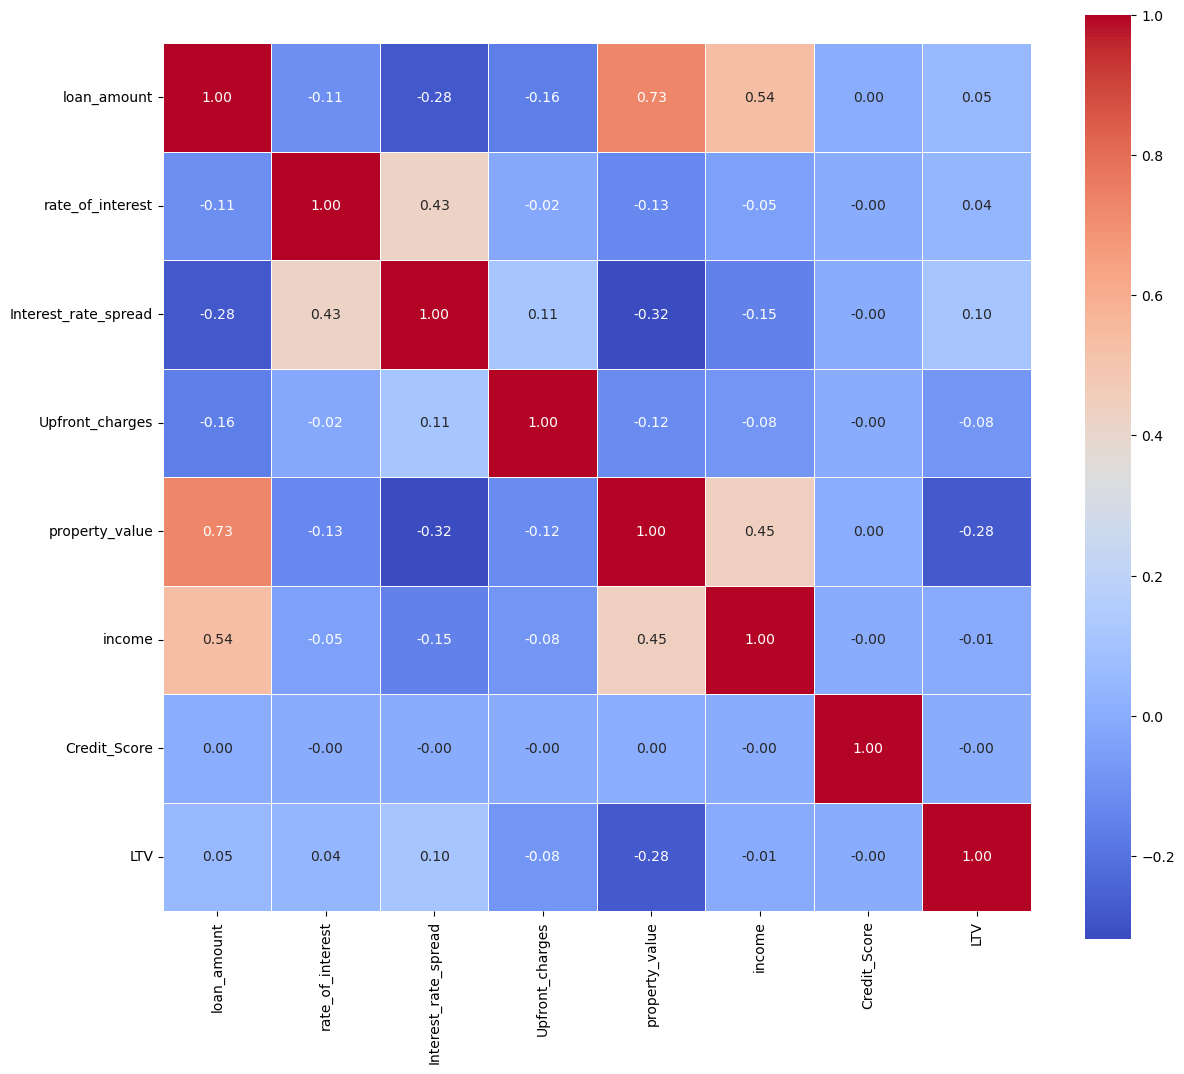

In [25]:
plt.figure(figsize=(14, 12))
sns.heatmap(filtered_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, linewidths=.5)
plt.show()

Determine which are the top features

In [27]:
top_corr_features

Index(['loan_amount', 'rate_of_interest', 'Interest_rate_spread',
       'Upfront_charges', 'property_value', 'income', 'Credit_Score', 'LTV'],
      dtype='object')

## Model Building and General Approach to Clustering with PCA and K-Means
The main goal of this code is to perform K-Means clustering on a dataset, after reducing its dimensionality with Principal Component Analysis (PCA). This approach helps in uncovering natural groupings within the data, which can then be analyzed for insights, such as customer segmentation or other business-relevant groupings. 

The dataset is large, we selected K-means in light of the size of the dataset and K-means time complexity. K-Means is generally efficient and scales well with large datasets due to its linear complexity with respect to the number of data points. However, the performance can degrade as the number of clusters (k) and dimensions (d) increases

.K-Means clustering works by iteratively assigning data points to clusters based on the closest centroid and updating the centroids until the clusters stabilize. This process groups similar data points together, allowing for the identification of distinct patterns or segments within the data.


When performing clustering analysis on a dataset, especially with a focus on reducing complexity and improving the interpretability of results, the following steps can be employed
:
### Why K-Means Clustering is a Good Choice for Segmenting the Loan Dataset:

1. **Diverse Feature Set**:
   - The dataset contains a variety of features, including numeric (e.g., `loan_amount`, `rate_of_interest`, `income`, `Credit_Score`, `LTV`, `dtir1`) and categorical variables (e.g., `Gender`, `loan_type`, `Region`, `credit_type`). These features provide a rich source of information to identify distinct groups of borrowers based on their financial behavior and characteristics.

2. **Large Dataset**:
   - With over 148,000 records, the dataset is large enough to benefit from clustering. K-Means can efficiently process this data to uncover patterns and segment the borrowers into meaningful groups, allowing for targeted strategies.

3. **Variety in Borrower Profiles**:
   - The presence of multiple financial and demographic features suggests that the borrowers in this dataset likely have varied profiles. K-Means can help identify these diverse groups, such as high-risk vs. low-risk borrowers or high-income vs. low-income borrowers, by clustering them based on their similarities.

4. **Missing Data Handling**:
   - Some columns have missing values (e.g., `rate_of_interest`, `Interest_rate_spread`, `property_value`, `income`). K-Means clustering can still be applied after handling these missing values (e.g., through imputation), which will allow you to segment the data despite these gaps.

5. **Business Insights**:
   - Segmentation using K-Means can provide actionable insights, such as identifying segments of borrowers who might need different loan products, different levels of risk management, or different marketing strategies. For example, one segment might consist of low-income borrowers with high credit scores who could be offered lower interest rates, while another segment might consist of high-income borrowers who could be targeted for premium loan products.

6. **Improving Decision-Making**:
   - Segmenting borrowers using K-Means can help in making better decisions related to loan approvals, interest rate assignments, risk assessment, and customer relationship management by understanding the distinct needs and behaviors of each segment.

### Summary:
K-Means clustering is a suitable choice for segmenting this loan dataset because it can efficiently process the large and diverse dataset, handle missing data, and provide meaningful insights into the different borrower profiles. This segmentation will enable more targeted and effective financial strategies, improving decision-making and  segmentation, market analysis, and product development.

### **Objective:**
The goal is to group data into distinct clusters using K-Means after reducing the dimensionality of the dataset with Principal Component Analysis (PCA). This approach helps in identifying natural groupings within the data that can be further analyzed for business insights.

### **Step 1: Standardizing the Data**
   - **Intent**: Ensure that all features contribute equally to the clustering process by standardizing them.
   - **Purpose**: Normalization removes biases due to varying scales among features, making the data suitable for both PCA and K-Means.

### **Step 2: Reducing Dimensionality with PCA**
   - **Intent**: Simplify the dataset by reducing its dimensions while retaining the maximum amount of information possible.
   - **Purpose**: Dimensionality reduction improves the performance and interpretability of the clustering algorithm, and also aids in visualization.

### **Step 3: Analyzing PCA Results**
   - **Intent**: Evaluate how much variance each principal component captures and understand the contribution of each original feature.
   - **Purpose**: Assess whether the dimensionality reduction is effective and identify which features are most influential in the reduced dimensions.

### **Step 4: Determining the Optimal Number of Clusters**
   - **Intent**: Use the Elbow Method to identify the optimal number of clusters for K-Means.
   - **Purpose**: Choosing the right number of clusters ensures the model captures the natural groupings in the data without overfitting or underfitting.

### **Step 5: Applying K-Means Clustering**
   - **Intent**: Assign data points to clusters based on the reduced dimensions from PCA.
   - **Purpose**: Discover hidden structures or patterns within the dataset, representing meaningful segments for analysis.

### **Step 6: Visualizing the Clustering Results**
   - **Intent**: Create visual representations of the clusters to understand how data points are grouped.
   - **Purpose**: Visualization aids in interpreting the clustering results and understanding the relationships between key variables.

### **Step 7: Analyzing Cluster Characteristics**
   - **Intent**: Summarize and interpret the characteristics of each cluster.
   - **Purpose**: Gain insights into the distinguishing traits of each segment, which can be applied in practical business or research contexts.

### **Overall Purpose:**
The overall purpose of this approach is to uncover meaningful groupings in the data, simplifying the analysis process with PCA, and enabling data-driven decisions through the interpretation of K-Means clustering results. This can be particularly useful in applications like customer segmentation, market analysis, and product development.

In [67]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

# Assume 'data' is your DataFrame and contains the features for PCA
features = data[top_corr_features]

# Standardize the data
scaler = RobustScaler()
scaled_features = scaler.fit_transform(features)

pca = PCA(n_components=4)  
pca_features = pca.fit_transform(scaled_features)

# Print the explained variance ratio for each principal component
print("Explained Variance Ratio for each Principal Component:")
for i, variance_ratio in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {variance_ratio:.4f}")

# Print the loadings (importance of each original feature in the principal components)
print("\nLoadings (Importance of Each Feature for Principal Components):")
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=features.columns)
print(loadings)

Explained Variance Ratio for each Principal Component:
PC1: 0.3516
PC2: 0.1921
PC3: 0.1293
PC4: 0.1138

Loadings (Importance of Each Feature for Principal Components):
                           PC1       PC2       PC3       PC4
loan_amount           0.187927  0.417251  0.077568  0.292944
rate_of_interest     -0.722114  0.531357  0.052890 -0.385646
Interest_rate_spread -0.597555 -0.179134  0.070481  0.669650
Upfront_charges      -0.067339 -0.338379  0.806315  0.030900
property_value        0.237031  0.468029  0.264283  0.160041
income                0.141794  0.414347  0.150430  0.401947
Credit_Score          0.001708  0.001198  0.001583 -0.001574
LTV                  -0.073046 -0.078963 -0.493555  0.359024


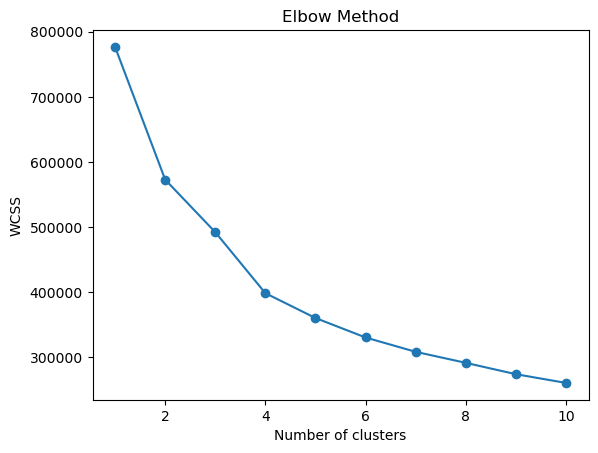

In [69]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(pca_features)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


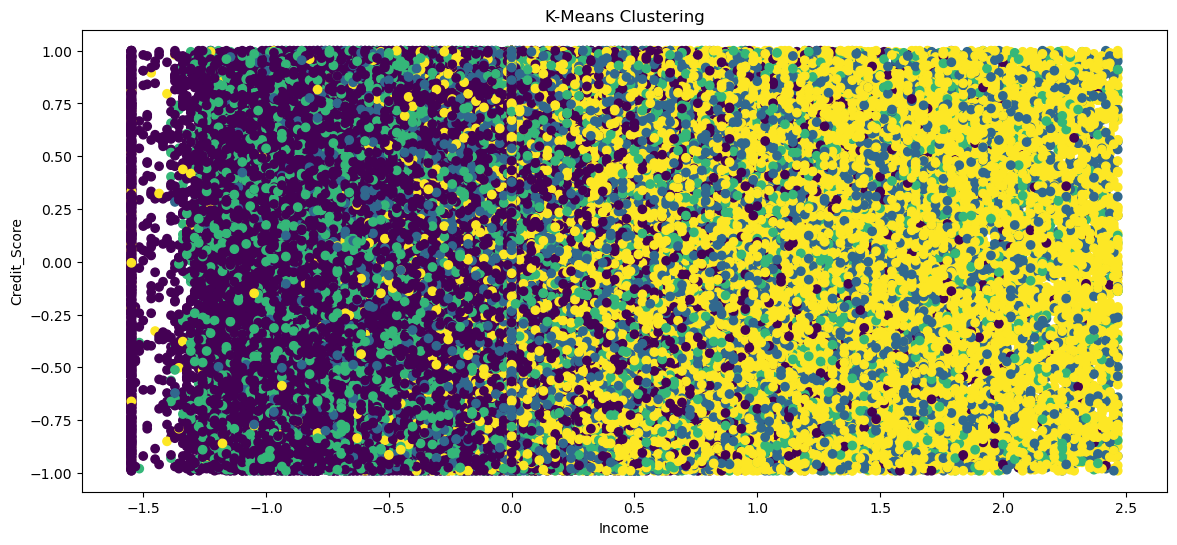

In [71]:
# Apply k-means clustering
kmeans = KMeans(n_clusters=4)
kmeans_labels = kmeans.fit_predict(pca_features)
# data['KMeans_Cluster'] = kmeans_labels

# Plot K-Means Clustering
plt.figure(figsize=(14, 6))
plt.scatter(data['income'], data['Credit_Score'], c=kmeans_labels)
plt.title('K-Means Clustering')
plt.xlabel('Income')
plt.ylabel('Credit_Score')
plt.show()



# Cluster Summary

**Intent**:
To summarize and interpret the characteristics of each cluster by calculating the mean values of the features for each group.

**Purpose**:
This step provides insights into what defines each cluster, making it easier to understand the distinguishing traits of each segment and apply this knowledge in practical business or research contexts.

In [73]:
cluster_summary = data.groupby('KMeans_Cluster').mean()
print(cluster_summary)


                Status  loan_amount  rate_of_interest  Interest_rate_spread  \
KMeans_Cluster                                                                
0                  0.0    -0.284016          0.340985              0.370371   
1                  0.0    -0.280011          0.268871              0.317610   
2                  0.0     0.782260         -0.266458             -0.602604   

                Upfront_charges  property_value    income  Credit_Score  \
KMeans_Cluster                                                            
0                      0.125138       -0.346844 -0.278229      0.519793   
1                      0.159913       -0.340194 -0.274364     -0.511141   
2                     -0.297462        0.808499  0.640736      0.009990   

                     LTV     dtir1  GMM_Cluster  
KMeans_Cluster                                   
0               0.048054  0.026215     1.631320  
1               0.040072  0.026699     1.624118  
2              -0.202250 -0.

# Analysis of K-Means cluster data

### **Cluster 0**:
- **Characteristics**: 
  - Lower-income borrowers with slightly lower loan amounts, higher credit scores, and below-average property values.
  - Loan-to-Value (LTV) and Debt-to-Income (DTI) ratios are close to average.
  
- **Insights**:
  - **Moderate Risk**: Higher credit scores indicate financial responsibility, making this a moderate-risk group.
  - **Up-selling Potential**: These borrowers could be targeted with financial products like credit cards or insurance that reward responsible financial behavior.
  - **Property Investment Opportunity**: Lower property values suggest a potential need for products aimed at property improvement or investment.
  - **Credit-based Offers**: Tailored loan offers or refinancing options could leverage their good credit standing to offer better terms.

### **Cluster 1**:
- **Characteristics**: 
  - Lower-income borrowers with lower credit scores, slightly lower property values, and higher upfront charges.
  - This cluster also has slightly lower loan amounts and average LTV and DTI ratios.
  
- **Insights**:
  - **Higher Risk**: The combination of lower credit scores and higher upfront charges suggests this group is higher risk.
  - **Supportive Services**: This cluster may benefit from financial counseling or products designed to help improve their creditworthiness.
  - **Risk Management**: More stringent risk assessment and management strategies may be needed for this group.

### **Cluster 2**:
- **Characteristics**: 
  - Higher-income borrowers with higher loan amounts, lower interest rates, and significantly higher property values.
  - This cluster also has lower LTV and DTI ratios and average credit scores.
  
- **Insights**:
  - **Lower Risk**: These borrowers likely represent a lower-risk, more affluent segment.
  - **Premium Products**: This cluster could be targeted with premium financial products and investment opportunities.
  - **Loyalty Programs**: Offering loyalty or reward programs could help retain these valuable customers and encourage them to consolidate their financial services with your institution.

### **Overall Summary**:
- **Cluster 0** is a moderate-risk group with potential for up-selling and property investment opportunities.
- **Cluster 1** is a higher-risk group that may require additional support and risk management.
- **Cluster 2** represents a lower-risk, affluent segment ideal for premium products and loyalty initiatives.

This comprehensive analysis can guide targeted marketing, product development, and risk management strategies across different customer segments.

## GaussianMixture

We repeat the above process, but this time using GaussianMixture to perform the clustering instead.

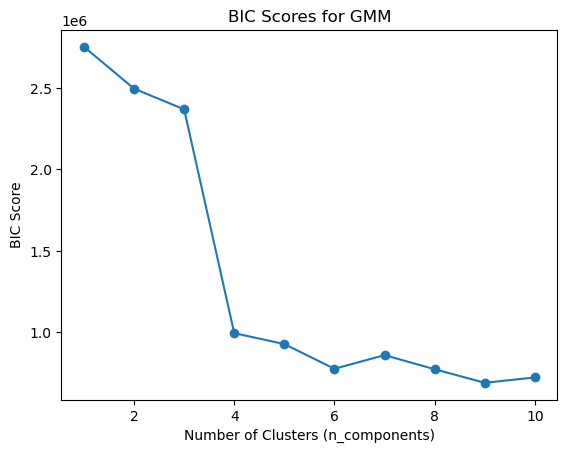

In [75]:
from sklearn.mixture import GaussianMixture

# Ran this once to get the elbow diagram, its quite slow, uncomment if you want to run it again

bic_scores = []
n_components_range = range(1, 11)

for n in n_components_range:
    gmm = GaussianMixture(n_components=n)
    gmm.fit(scaled_features)
    bic_scores.append(gmm.bic(scaled_features))

# Plot the BIC scores
plt.plot(n_components_range, bic_scores, marker='o')
plt.title('BIC Scores for GMM')
plt.xlabel('Number of Clusters (n_components)')
plt.ylabel('BIC Score')
plt.show()

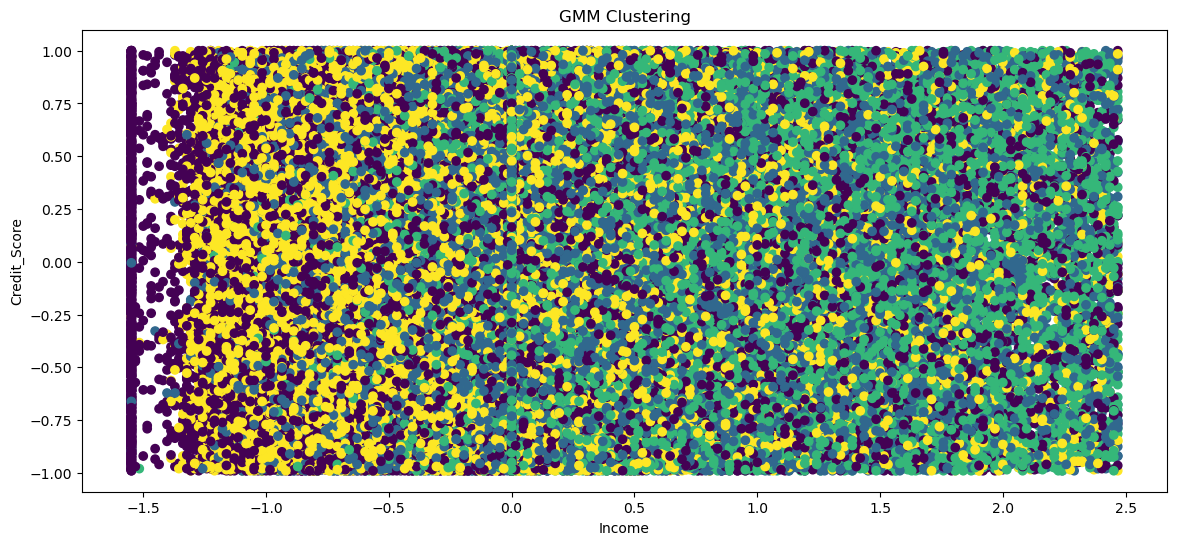

In [78]:
gmm = GaussianMixture(n_components=4)
gmm_labels = gmm.fit_predict(pca_features)

# Add cluster labels to the original dataframe for both methods
# data['GMM_Cluster'] = gmm_labels

# Plot GMM Clustering
plt.figure(figsize=(14, 6))
plt.scatter(data['income'], data['Credit_Score'], c=gmm_labels)
plt.title('GMM Clustering')
plt.xlabel('Income')
plt.ylabel('Credit_Score')

plt.show()



In [89]:
cluster_summary = data.groupby('GMM_Cluster').mean()
print(cluster_summary)


             Status  loan_amount  rate_of_interest  Interest_rate_spread  \
GMM_Cluster                                                                
0               0.0     0.626973          0.098840             -0.253171   
1               0.0    -0.097378         -0.020703              0.009730   
2               0.0     0.191117         -0.893472             -0.872010   
3               0.0    -0.490551          1.110438              1.126667   

             Upfront_charges  property_value    income  Credit_Score  \
GMM_Cluster                                                            
0                  -0.571696        0.480577  0.557850      0.002143   
1                   0.019642       -0.194804 -0.226371      0.004500   
2                   0.484323        0.545847  0.127268      0.009401   
3                   0.329357       -0.593328 -0.389816      0.001074   

                  LTV     dtir1  KMeans_Cluster  
GMM_Cluster                                      
0         

### Analysis of GMM Cluster Data

This new dataset represents the summary statistics for four different clusters identified through a Gaussian Mixture Model (GMM) clustering. Here's the analysis of each GMM cluster and a comparison against the previous K-Means cluster analysis:

### **GMM Cluster 0**:
- **Characteristics**:
  - **Loan Amount**: Higher than average, indicated by the positive value.
  - **Rate of Interest**: Slightly above average.
  - **Interest Rate Spread**: Slightly below average.
  - **Upfront Charges**: Significantly lower than average.
  - **Property Value**: Higher than average.
  - **Income**: Higher than average.
  - **Credit Score**: Around the average.
  - **LTV (Loan-to-Value Ratio)**: Higher than average.
  - **DTI (Debt-to-Income Ratio)**: Slightly below average.
  - **KMeans Cluster**: Mostly corresponds to Cluster 1.

**Comparison**:
- **K-Means Cluster 1** (lower credit scores, slightly below-average property values): GMM Cluster 0 seems to encompass some of the more affluent and lower-risk individuals from Cluster 1, with higher income, property values, and loan amounts. The significant decrease in upfront charges contrasts with the higher upfront charges seen in K-Means Cluster 1.

### **GMM Cluster 1**:
- **Characteristics**:
  - **Loan Amount**: Slightly below average.
  - **Rate of Interest & Interest Rate Spread**: Near average.
  - **Upfront Charges**: Near average.
  - **Property Value**: Below average.
  - **Income**: Below average.
  - **Credit Score**: Near average.
  - **LTV**: Slightly above average.
  - **DTI**: Above average.
  - **KMeans Cluster**: Corresponds mostly to Cluster 0.

**Comparison**:
- **K-Means Cluster 0** (lower-income borrowers, higher credit scores): GMM Cluster 1 closely aligns with K-Means Cluster 0 but with a bit more variation in interest rates and upfront charges. Both clusters represent lower-income borrowers with below-average property values but with different risk profiles.

### **GMM Cluster 2**:
- **Characteristics**:
  - **Loan Amount**: Slightly above average.
  - **Rate of Interest**: Near average.
  - **Interest Rate Spread**: Significantly below average.
  - **Upfront Charges**: Higher than average.
  - **Property Value**: Higher than average.
  - **Income**: Above average.
  - **Credit Score**: Near average.
  - **LTV**: Significantly below average.
  - **DTI**: Below average.
  - **KMeans Cluster**: Mostly corresponds to Cluster 1.

**Comparison**:
- **K-Means Cluster 1**: GMM Cluster 2 appears to focus on a segment with better financial profiles than the general population of K-Means Cluster 1. This cluster has higher property values and income, along with significantly lower LTV ratios, indicating a potentially lower-risk segment.

### **GMM Cluster 3**:
- **Characteristics**:
  - **Loan Amount**: Below average.
  - **Rate of Interest & Interest Rate Spread**: Significantly above average.
  - **Upfront Charges**: Higher than average.
  - **Property Value**: Significantly below average.
  - **Income**: Below average.
  - **Credit Score**: Near average.
  - **LTV**: Slightly below average.
  - **DTI**: Near average.
  - **KMeans Cluster**: Corresponds mostly to Cluster 2.

**Comparison**:
- **K-Means Cluster 2** (higher-income borrowers, higher loan amounts, lower interest rates): GMM Cluster 3 represents a contrast, focusing on a lower-income, higher-risk group with higher interest rates and upfront charges. This cluster may have a higher risk than the generally lower-risk population in K-Means Cluster 2.

### **Overall Comparison and Insights**:

- **Alignment and Differences**: The GMM clusters show some alignment with the K-Means clusters but also introduce variations that provide a more nuanced segmentation. For example, GMM Cluster 0 and 2 represent higher-income groups, but with different levels of loan amounts and risk profiles, while GMM Cluster 3 highlights a more vulnerable, higher-risk segment than any of the original K-Means clusters.
  
- **Segment Refinement**: The GMM clusters offer a more refined segmentation that can help in better targeting of financial products, risk assessment, and customer support. For example, GMM Cluster 3 highlights a group that might require more stringent risk management, while GMM Cluster 0 could be targeted with premium products due to its higher property values and income.

- **Strategic Implications**: The differences in interest rates, upfront charges, and loan amounts between GMM and K-Means clusters suggest that a more detailed analysis (like GMM) can uncover hidden segments within broader groups, leading to more effective and targeted business strategies.

This refined clustering through GMM provides deeper insights into the customer segments, allowing for more tailored marketing, product development, and risk management strategies compared to the initial K-Means analysis.

# Metrics

## What is Silhouette Score?

The **Silhouette Score** is a metric used to evaluate the quality of clustering. It measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The score ranges from -1 to 1:

- **+1**: Indicates that the data point is well matched to its own cluster and poorly matched to neighboring clusters.
- **0**: Indicates that the data point is on or very close to the decision boundary between two neighboring clusters.
- **-1**: Indicates that the data point might have been assigned to the wrong cluster, as it is closer to a different cluster than the one it is assigned to.

In [93]:
from sklearn.metrics import silhouette_score

# Calculate silhouette scores for both models
kmeans_silhouette = silhouette_score(scaled_features, kmeans_labels)
gmm_silhouette = silhouette_score(scaled_features, gmm_labels)

print(f'K-Means Silhouette Score: {kmeans_silhouette:.3f}')
print(f'GMM Silhouette Score: {gmm_silhouette:.3f}')

K-Means Silhouette Score: 0.175
GMM Silhouette Score: 0.049


## Discussion 

1. **K-Means Silhouette Score: 0.175**
   - **Interpretation**: A silhouette score of 0.175 for K-Means clustering suggests that the clusters are somewhat distinct but not highly separated. While the clusters are more cohesive than random groupings, there may still be significant overlap between the clusters. This could mean that some data points are not clearly assignable to a single cluster and are somewhat ambiguous.
   - **Implications**: The moderate silhouette score indicates that while K-Means has been able to group similar data points together to some extent, the cluster boundaries are not particularly strong. Further refinement of the clustering process or the use of additional features might improve the clustering quality.

2. **GMM Silhouette Score: 0.049**
   - **Interpretation**: A silhouette score of 0.049 for GMM clustering indicates that the clusters are not very distinct, with significant overlap between them. The low score suggests that many data points are either poorly assigned to their current cluster or lie very close to the boundary between clusters.
   - **Implications**: The GMM clusters are less distinct compared to the K-Means clusters. This could be due to the nature of GMM, which allows for soft clustering (where data points can belong to multiple clusters with different probabilities) as opposed to K-Means' hard clustering. The low silhouette score might suggest that GMM is capturing some underlying structure that K-Means is not, but it also indicates that this structure is not as clearly defined in terms of separation between clusters.

### Overall Comparison

- **K-Means**: With a silhouette score of 0.175, K-Means has produced clusters that are somewhat distinct, but there's room for improvement. The higher silhouette score compared to GMM suggests that K-Means clusters are more cohesive and better separated.
- **GMM**: The lower silhouette score of 0.049 indicates that GMM clustering has resulted in less distinct clusters, possibly due to the soft clustering nature of the algorithm. While GMM might capture more nuanced relationships between data points, the overall separation of cluste

### Suggestions for Improvements

To improve the silhouette scores for K-Means and GMM clustering:

- **K-Means**:
  - **Optimize the Number of Clusters**: Use methods like the Elbow Method to find the best `k`.
  - **Feature Selection and Engineering**: Focus on relevant features and create new, informative ones.
  - **Data Scaling**: Ensure all features are on the same scale.
  - **Outlier Removal**: Detect and remove outliers to enhance cluster cohesion.
  - **Dimensionality Reduction**: Apply techniques like PCA to reduce data complexity.

- **GMM**:
  - **Optimize the Number of Components**: Use BIC or AIC to select the optimal number of clusters.
  - **Tune Covariance Type**: Experiment with different covariance structures.
  - **Regularization**: Apply regularization to stabilize the clustering process.
  - **Improved Initialization**: Use better initialization strategies like k-means++.
  - **Consider Alternative Algorithms**: If GMM assumptions don’t fit, explore other clustering methods like DBSCAN or Hierarchical Clustering.

These steps can help achieve more distinct, well-separated clusters and improve overall clustering quality.rs is weaker.

### Summary

- The **Silhouette Score** evaluates the quality of clustering by measuring how well data points are matched to their assigned clusters versus other clusters.
- The **K-Means Silhouette Score** of 0.175 suggests moderate clustering quality, with some overlap between clusters but generally reasonable separation.
- The **GMM Silhouette Score** of 0.049 indicates that the clusters are not well separated, potentially due to the algorithm's soft clustering approach, which might capture more complex relationships but results in less distinct clusters.

